# **Data Preprocessing**

In this notebook, we will learn about the basics of data preprocessing. 

At the start, we will generate a toy **data set** and download an image data set.

Subsequently, we will **standardize** both data sets.

In a next step, we will implement the **principal component analysis** (PCA) algorithm and apply it on the artificial data set.

Finally, we will test the performance of the PCA on the image data set.

### **Table of Contents**
1. [Data Sets](#data-sets)
2. [Standardization](#standardization)
3. [PCA on Toy Data Set](#pca-on-toy-data-set)
4. [PCA on Image Data Set](#pca-on-image-data-set)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import timeit
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, Button, fixed
from sklearn.datasets import fetch_openml

### **1. Data Sets** <a class="anchor" id="data-sets"></a>

In this notebook, we will consider two kinds of data sets:
- a two-dimensional toy data set to illustrate eigenvectors
- and the image data set [MNIST](https://www.openml.org/d/554) containing images of hand-written digits.

Mathematically, we denote an obtained data set consisting of $N$ instances (also referred to as sample) as a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$, where the $n$-th row of this matrix represents the $n$-th instance being a $D$-dimensional feature vector: $\mathbf{x}_n = (x_{n1}, \dots, x_{nD})^\mathrm{T}$.

Below, we generate the toy data set, download the image data set, and visualize both.

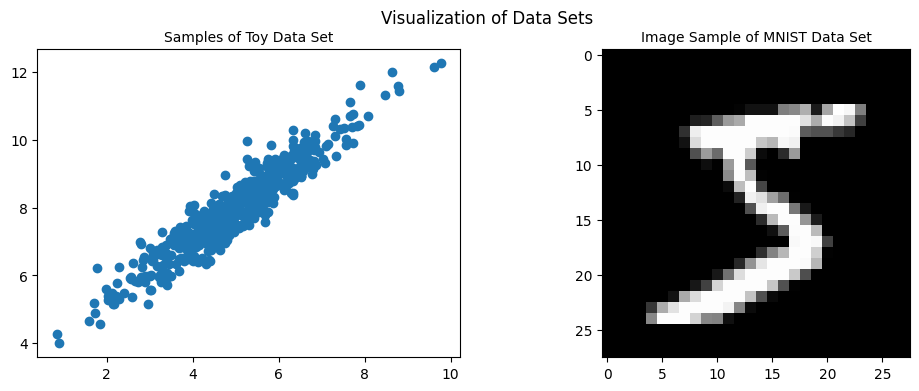

In [2]:
# Generate 500 samples using a 2-dimensional multivariate normal distributions with a mean=[5, 8] and
# a covariance matrix cov=[[2, 1.9], [1.9, 2]]
mean = [5, 8]
cov = [[2, 1.9], [1.9, 2]]
X_toy = np.random.multivariate_normal(mean, cov, 500)

# Download MNIST data set.
X_img, y_img = fetch_openml('mnist_784', version=1, return_X_y=True)
X_img, y_img = X_img.values, y_img.values.astype(int)

# Plot data sets.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Visualization of Data Sets')
ax[0].scatter(X_toy[:, 0], X_toy[:, 1])
ax[0].set_title('Samples of Toy Data Set', fontsize=10)
ax[1].imshow(X_img[0].reshape(28, 28), cmap='gray')
ax[1].set_title('Image Sample of MNIST Data Set', fontsize=10)
plt.show()

### **2. Standardization** <a class="anchor" id="standardization"></a>

Before we implement PCA, we will need to standardize the data sets. The feature value $x_{*d}$ of an instance $\mathbf{x}_*$ can be standardized according to

_Answer:_
    $ \tilde{x}_{*d} = \frac{x_{*d} - \mu_d}{\sigma_d} $
    where $\mu_d$ and $\sigma_d$ denote the mean and standard deviation of the $d$-th feature, respectively.

The standardization ensures that the instances will have zero mean and one variance.

We need to implement the corresponding class [`StandardScaler`](../e2ml/preprocessing/_standard_scaler.py) in the [`e2ml.preprocessing`](../e2ml/preprocessing) subpackage.
Once, the implementation has been completed, we actually standardize both data sets and visualize the results, and check our implementation's validity. 

a:\uni\8.sem\e2ml\exercise\e2ml\preprocessing\_standard_scaler.py:62: RuntimeWarning: invalid value encountered in true_divide
  Z = np.nan_to_num((X - self.mu_) / self.sigma_)


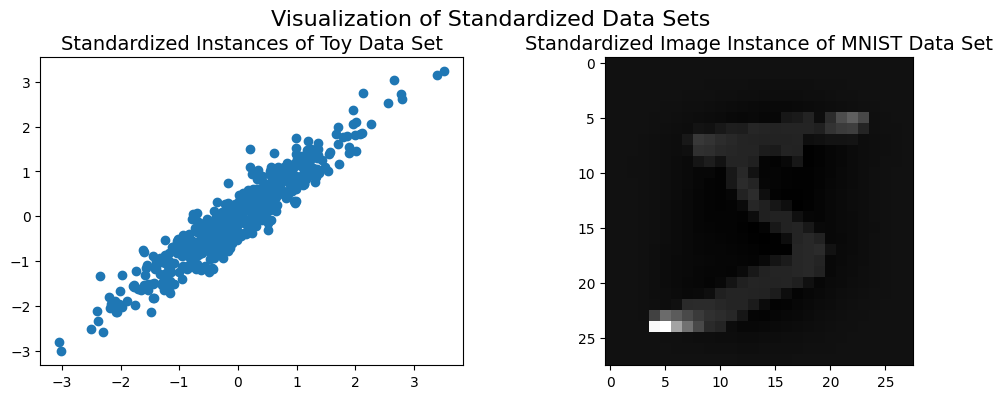

In [3]:
from e2ml.preprocessing import StandardScaler

# Fit StandardScaler on the toy data set.
scaler_toy = StandardScaler()
scaler_toy.fit(X_toy)

# Use scaler to standardize the toy data set.
X_toy_std = scaler_toy.transform(X_toy)

assert np.allclose(np.std(X_toy_std, axis=0), np.ones(X_toy_std.shape[1])), 'The standard deviations are not one.'
assert np.allclose(np.mean(X_toy_std, axis=0), np.zeros(X_toy_std.shape[1])), 'The means are not zero.'

# Fit StandardScaler on the MNIST data set.
scaler_img = StandardScaler()
scaler_img.fit(X_img)

# Use scaler to standardize the MNIST data set.
X_img_std = scaler_img.transform(X_img)

# Plot data sets.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Visualization of Standardized Data Sets', fontsize=16, y=1)
ax[0].scatter(X_toy_std[:, 0], X_toy_std[:, 1])
ax[0].set_title('Standardized Instances of Toy Data Set', fontsize=14)
ax[1].imshow(X_img_std[0].reshape(28, 28), cmap='gray')
ax[1].set_title('Standardized Image Instance of MNIST Data Set', fontsize=14)
plt.show()

#### **Question:**
2. (a) Why should we standardize data before applying PCA?

   _Answer:_
      PCA is sensitive to the scale of the features. If the features are not standardized, the principal components will be dominated by the features with the largest scale.

### **3. PCA on Toy Data Set** <a class="anchor" id="pca-on-toy-data-set"></a>

Now we will implement PCA given a training set $\mathbf{X}$ with mean $\mathbf{\overline{x}} \in \mathbb{R}^D$ (being $\mathbf{0}$ if $\mathbf{X}$ has been standardized) to transform samples from the $D$-dimensional space into an $M \leq D$ dimensional space. 
We then need to perform the following steps.

1. Compute the (biased) covariance matrix $\boldsymbol{\Sigma} \in \mathbb{R}^{D \times D}_{\geq 0}$:
   $$\begin{equation}
   \boldsymbol{\Sigma} = \frac{1}{N} \sum_{n=1}^{N} (\mathbf{x}_n-\mathbf{\overline{x}}) (\mathbf{x}_n-\mathbf{\overline{x}})^\mathrm{T}.
   \end{equation}$$
2. Determine the eigenvector matrix $\mathbf{U} \in \mathbb{R}^{D \times D}$ of $\boldsymbol{\Sigma}$ including their corresponding eigenvalues $\boldsymbol{\lambda} \in \mathbb{R}^D$:
    $$\begin{equation}
       \boldsymbol{\Sigma}\mathbf{u}_i = \lambda_i\mathbf{u}_i,
    \end{equation}$$
    where $\mathbf{u}_i$ is the $i$-th column of the matrix $\mathbf{U}$ and $\lambda_i$ its eigenvalue.
3. After these steps, we can then compute the projection matrix $\mathbf{B} \in \mathbb{R}^{D \times M}$ by selecting the top $M$ eigenvectors:
    $$\begin{equation}
       \mathbf{B} = \begin{bmatrix} \mathbf{u}_{i_1}, \dots, \mathbf{u}_{i_M} \end{bmatrix} \text{ subject to } \lambda_{i_1} \geq \dots \geq \lambda_{i_M} \text{ and } \lambda_{i_M} \geq \lambda_j \text{ for all } j \in \{1, \dots, D\} \setminus \{i_1, \dots, i_M\}.
    \end{equation}$$
4. Finally, we can transform a sample $\mathbf{x}_*$ according to
   $$\begin{equation}
   \mathbf{z}_{*} = \mathbf{B}^\mathrm{T}(\mathbf{x}_*-\mathbf{\overline{x}}),
   \end{equation}$$
   and retransform it to the original space through
   $$\begin{equation}
   \tilde{\mathbf{x}}_{*} = \mathbf{B}\mathbf{z}_* + \mathbf{\overline{x}}.
   \end{equation}$$
   
A common way to determine the number of principal components $M$ is to define a threshold $c \in (0, 1]$ for the **explained variance** such that 
$$\begin{equation}
M_c = \text{arg min}_{M \in \{1, \dots, D\}} (M) \text{ subject to } \frac{\sum_{j=1}^{M} \lambda_{i_j}}{\sum_{i=l}^{D} \lambda_{l}} \geq c.
\end{equation}$$

   
#### **Question:**
3. (a) In which case is the retransformation $\tilde{\mathbf{x}}_{*}$ according to step 4 equal to $\mathbf{x}_{*}$. We assume that all $D$ eigenvalues  in $\boldsymbol{\lambda}$ are positive?

   _Answer:_
      If $M = D$ and $\mathbf{B} = \mathbf{U}$, then $\tilde{\mathbf{x}}_{*} = \mathbf{x}_{*}$.
   
Having implemented the class [`PrincipalComponentAnalysis`](../e2ml/preprocessing/_principal_component_analysis.py) in the [`e2ml.preprocessing`](../e2ml/preprocessing) subpackage, we apply it to the two-dimensional toy data set to visualize eigenvectors and eigenvalues.

u shape:  (2,)
pca.mu_ shape:  (2,)
u shape:  (2,)
pca.mu_ shape:  (2,)


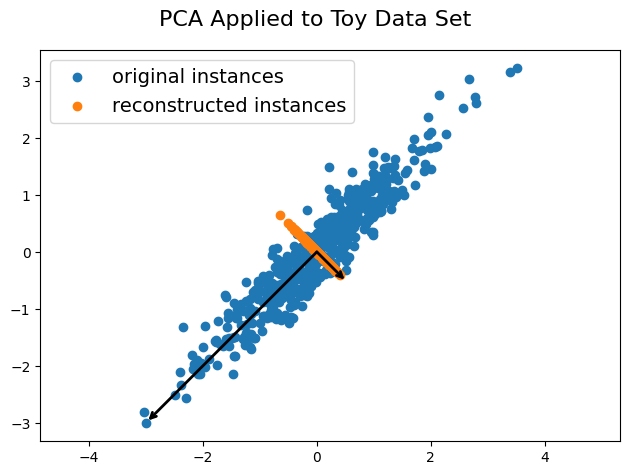

In [4]:
from e2ml.preprocessing import PrincipalComponentAnalysis

# Fit PrincipalComponentAnalysis object with M=1.
pca = PrincipalComponentAnalysis(n_components=1)
pca.fit(X_toy_std)

# Transform instances of standardized toy data set.
X_toy_pca = pca.transform(X_toy_std)

# Reconstruct original instances from instances samples.
X_rec = pca.inverse_transform(X_toy_pca)
    
# Visualize results of PCA.
plt.figure()
plt.suptitle("PCA Applied to Toy Data Set", fontsize=16)
plt.scatter(X_toy_std[:, 0], X_toy_std[:, 1], label='original instances')
plt.scatter(X_rec[:, 0], X_rec[:, 1], label='reconstructed instances')
for lmbda, u in zip(pca.lmbdas_, pca.U_.T):
    u = u * 3 * np.sqrt(lmbda)
    print("u shape: ", u.shape)
    print("pca.mu_ shape: ", pca.mu_.shape)
    plt.annotate('', pca.mu_ + u, pca.mu_, arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
plt.axis('equal')
plt.legend(prop={'size': 14})
plt.tight_layout()
plt.show()

### **4. PCA on Image Data Set** <a class="anchor" id="pca-on-image-data-set"></a>

In this section, we will analyze the performance of the PCA on the image data set MNIST. Therefor, we analyze how the number of selected principal components $M$ affects our reconstruction error be.
First, we have to implement a function for computing the reconstruction error (i.e., mean squared error):
\begin{equation}
J = \frac{1}{N} \sum_{n=1}^{N} ||\mathbf{x}_n - \tilde{\mathbf{x}}_{n}||^2.
\end{equation}

In [5]:
def compute_reconstruction_error(X_orig, X_rec):
    """Computes the reconstruction error, i.e., mean squared error.
    
    Parameters
    ----------
    X_orig : array-like, shape (N, D)
        Original samples.
    X_rec : array-like, shape (N, D)
        Reconstructed samples.
        
    Returns
    -------
    J : float
        Reconstruction error.
    """
    return np.sum(np.square(X_orig - X_rec), axis=1).mean()

In a second step, we will now compute the error in dependence of the number of selected components $M$.

0 completed.
1 completed.
2 completed.
3 completed.
4 completed.
5 completed.
6 completed.
7 completed.
8 completed.
9 completed.
10 completed.
11 completed.
12 completed.
13 completed.
14 completed.
15 completed.
16 completed.
17 completed.
18 completed.
19 completed.
20 completed.
21 completed.
22 completed.
23 completed.
24 completed.
25 completed.
26 completed.
27 completed.
28 completed.
29 completed.
30 completed.
31 completed.
32 completed.
33 completed.
34 completed.
35 completed.
36 completed.
37 completed.
38 completed.
39 completed.
40 completed.
41 completed.
42 completed.
43 completed.
44 completed.
45 completed.
46 completed.
47 completed.
48 completed.
49 completed.


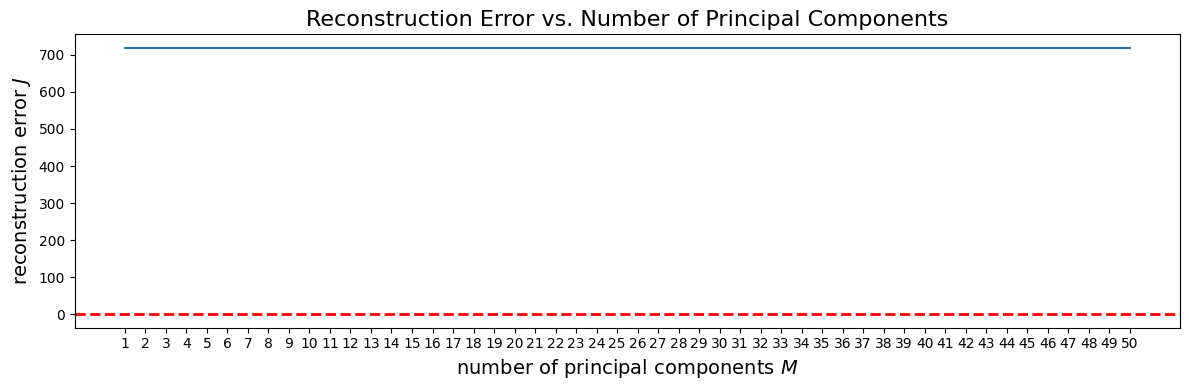

In [9]:
# Create `M_list` as array of M's ranging from 1 to 50.
M_list = np.arange(1, 51)

# Iterate over different numbers of principal components M, compute the 
# reconstruction errors, and save them in `J_list`.
J_list = np.empty_like(M_list)
for i, M in enumerate(M_list):
    pca = PrincipalComponentAnalysis(M)
    pca.fit(X_img_std)
    X_img_pca = pca.transform(X_img_std)
    X_img_rec = pca.inverse_transform(X_img_pca)
    J_list[i] = compute_reconstruction_error(X_img_std, X_img_rec)
    if i % 10 == 0:
        print(str(i) + " completed.")
    
# Plot reconstruction error.
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(M_list, J_list)
ax.xaxis.set_ticks(M_list)
ax.axhline(xmin=0, xmax=1, linestyle='--', color='r', linewidth=2)
ax.set_xlabel('number of principal components $M$', fontsize=14)
ax.set_ylabel('reconstruction error $J$', fontsize=14)
ax.set_title('Reconstruction Error vs. Number of Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

#### **Question:**
4. (a) How can we use the eigenvalues for computing the reconstruction error on the training set?

   _Answer:_
      We can use the eigenvalues for computing the reconstruction error on the training set by computing the reconstruction error for each $M$ and summing up the corresponding eigenvalues.
   
Finally, we show the qualitative performance of the PCA through visual inspections of examples for different values of the explained variance.

In [10]:
@interact(image_idx=(0, len(X_img_std)-1), x0=fixed(28), x1=fixed(28), X=fixed(X_img_std), scaler=fixed(scaler_img))
def show_explained_variance_reconst(image_idx, x0, x1, X, scaler):
    """
    Shows the reconstruction of image `X[image_idx]` for different values `c` of explained
    variances.
    
    Parameters
    ----------
    image_idx : int
        Index of image to be reconstructed.
    x0 : int
        Number of pixels in first dimension.
    x1 : int
        Number of pixels in second dimension.
    X : array-like, shape (N, D)
        Images to be reconstracted.
    scaler : StandardScaler
        Fitted scaler to invert standardization.
    """
    # Define list of explained variances.
    c_list = np.array([0.01, 0.10, 0.50, 0.90, 0.99])
    
    # Plot original digit.
    fig, ax = plt.subplots(1, len(c_list)+1, figsize=(20, 4))
    ax[0].imshow(scaler.inverse_transform([X[image_idx]]).reshape(x0, x1), cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
        
    # Plot reconstructed digits for different values of explained variances.
    for i, c in enumerate(c_list):
        # Fit PrincipalComponentAnalysis with explained variance `c`.
        pca = PrincipalComponentAnalysis(c)
        pca.fit(X)
        
        # Transform instance with index `image_idx` and save it as `z_selected`.
        z_selected = pca.transform([X[image_idx]])
        
        # Reconstruct instance `x_rec_selected` from `z_selected`.
        x_rec_selected = pca.inverse_transform(z_selected)
        
        # Plot reconstructed instance with index image_idx.
        ax[i+1].imshow(scaler.inverse_transform(x_rec_selected).reshape(x0, x1), cmap='gray')
        ax[i+1].set_title(
            f'Explained Variance: $c={c}$,\n Number of Components $M={pca.n_components_}$', fontsize=14
        )
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=34999, description='image_idx', max=69999), Output()), _dom_classes=('wi…